In [0]:
#import numpy

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from keras.layers.core import Dense, Activation

import re
import csv
import pickle
from string import punctuation
import nltk 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import pickle
import numpy as np
import pandas as pd
                                                 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:


#RÉCUPÉRATION DES TAGS
f=open("/data_task3/train.txt", "r")
data=[]
contents =[line for line in f.readlines() if line.strip()]
indx=0
for x in contents:
    words=x.split()
   
    if words[0]=="SAMPLE_START":
         indx+=1
    data.append([indx,words[0],words[1]])
data= pd.DataFrame(data, columns=['sentence', 'word', 'tag'])
print (data.head(10))



f=open("/data_task3/train.txttest.data", "r")
datatest=[]
contents =[line for line in f.readlines() if line.strip()]
indx=0
for x in contents:
    words=x.split()
    if words[0]=="SAMPLE_START":
         indx+=1
    datatest.append([indx,words[0]])
datatest= pd.DataFrame(datatest, columns=['sentence', 'word'])
print (datatest.head(10))

f=open("/data_task3/china_test.data", "r")
datachina=[]
contents =[line for line in f.readlines() if line.strip()]
indx=0
for x in contents:
    words=x.split()
    if words[0]=="SAMPLE_START":
         indx+=1
    datachina.append([indx,words[0]])
datachina= pd.DataFrame(datachina, columns=['sentence', 'word'])
print (datachina.head(10))



Mounted at /content/drive
   sentence          word            tag
0         1  SAMPLE_START              O
1         1   KRISHNAGIRI              O
2         1             /              O
3         1    DHARMAPURI              O
4         1             :              O
5         1         Water              O
6         1        supply              O
7         1     disrupted              O
8         1             ,              O
9         1     villagers  B-participant
   sentence           word
0         1   SAMPLE_START
1         1        Members
2         1             of
3         1       Moopanar
4         1        Peravai
5         1         staged
6         1              a
7         1  demonstration
8         1             in
9         1          Salem
   sentence          word
0         1  SAMPLE_START
1         1      Facebook
2         1             ,
3         1         which
4         1           has
5         1           1.2
6         1       billion
7         1       

In [0]:
words = list(set(data["word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

tags = list(set(data["tag"].values))
n_tags = len(tags); n_tags

print(n_words)
print(words)
print(tags)

5172
['know', 'protectors', '150', 'uninterrupted', 'Hyderabad', 'Sinha', 'dust', 'emanating', 'Six', 'squatted', 'decrying', 'orgainsed', 'Pravash', 'diseases', 'Dor', 'organisations', 'started', '2001', 'mediapersons', 'office-bearers', 'ongoing', 'family', 'hands', 'tahsil', 'filing', 'my', 'Superintending', 'difference', 'instill', 'repeated', 'counting', 'observed', 'Bundu', 'laid', 'exhorting', 'engines', 'guarded', 'Roopanwal', 'HESCO', 'raising', 'seven', 'HCL', 'sternly', 'helped', 'breakthrough', 'Suspected', 'abstained', 'forms', 'Kadapa', 'Shiggaon', 'General', '2017', 'contain', 'Mayiladuthurai', 'Tuesday', 'agrees', 'volunteers', 'Multai', 'PUSU', 'indefinitely', 'P', 'encounter', '`', 'although', 'Kanpur', 'impsed', 'cultural', 'spreads', 'youths', 'provision', 'Sankarapandian', 'jobless', 'Kasimedu', 'halt', 'militants', 'Pradesh', 'Vemula', 'inebriated', 'Tax', 'decisive', 'jail', 'migrants', 'Tandwa-Navinagar', '03:22', 'signifying', 'MPTC', 'MLCs', 'talk', 'falls', '

In [0]:
wordstest = list(set(datatest["word"].values))
wordstest.append("ENDPAD")
n_words = len(wordstest); n_words
print(n_words)
print(wordstest)

wordstestchina = list(set(datachina["word"].values))
wordstestchina.append("ENDPAD")
n_words = len(wordstestchina); n_words
print(n_words)
print(wordstestchina)

2064
['150', 'Hyderabad', 'Poor', 'weavers', 'lights', 'organisations', 'protecting', 'Radhakrishnan', 'ongoing', 'family', 'my', 'observed', 'Land', 'raising', 'seven', 'rivers', 'appeal', 'Probe', 'abetment', 'abstained', 'manner', 'Kadapa', 'General', '2017', 'Tuesday', 'volunteers', 'indefinitely', '`', 'Ravi', 'encounter', 'youths', 'jail', 'militants', 'Pradesh', 'launch', 'Haragopal', 'confederation', 'Plant', 'and', 'transgenders', 'fan', 'armed', 'might', 'administrator', 'duties', 'Irapuram', 'learnt', 'action', 'RAMESWARAM', 'over', 'Gopalakrishnan', 'offers', '1,000', 'Party', 'reservation', 'diplomat', 'reply', 'lathicharge', 'name', 'The', 'alignment', 'University', 'In', 'More', 'investigation', 'bandwagon', 'an', 'SALEM', 'State-run', 'demolished', 'Investigators', 'railways', 'Chennai', 'though', 'entered', 'tahsildar', 'visitors', 'Auditorium', 'tantri', '24', 'justice', 'taken', 'face', 'resolve', 'arrested', 'yesterday', 'clear', '2010', 'organisation', 'March', 'gr

In [0]:

class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                       
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
getter = SentenceGetter(data)
sentences = getter.sentences    
print(sentences)

[[('SAMPLE_START', 'O'), ('KRISHNAGIRI', 'O'), ('/', 'O'), ('DHARMAPURI', 'O'), (':', 'O'), ('Water', 'O'), ('supply', 'O'), ('disrupted', 'O'), (',', 'O'), ('villagers', 'B-participant'), ('block', 'B-trigger'), ('road', 'B-loc'), ('September', 'O'), ('04', 'O'), (',', 'O'), ('2014', 'O'), ('00:00', 'O'), ('IST', 'O'), ('Officials', 'O'), ('promise', 'O'), ('to', 'O'), ('supply', 'O'), ('water', 'O'), ('in', 'O'), ('tankers', 'O'), ('Women', 'B-participant'), ('took', 'B-trigger'), ('to', 'I-trigger'), ('streets', 'I-trigger'), ('carrying', 'O'), ('pots', 'O'), ('in', 'O'), ('protest', 'O'), ('against', 'O'), ('erratic', 'O'), ('supply', 'O'), ('of', 'O'), ('drinking', 'O'), ('water', 'O'), ('at', 'O'), ('Kelamagalam', 'B-place'), ('in', 'O'), ('Udhanapalli', 'B-place'), ('on', 'B-etime'), ('Wednesday', 'I-etime'), ('.', 'O'), ('[SEP]', 'O'), ('The', 'O'), ('protesters', 'B-participant'), ('blocked', 'B-trigger'), ('the', 'O'), ('Rayakottai', 'B-fname'), ('road', 'I-fname'), ('.', 'O'

In [0]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w) for w in zip(s["word"].values.tolist()
                                                       
                                                      )]
        self.grouped = self.dataset.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
getter = SentenceGetter(datatest)
sentencestest = getter.sentences    
print(sentencestest)

getter = SentenceGetter(datachina)
sentencestestchina = getter.sentences    
print(sentencestestchina)

[[('SAMPLE_START',), ('Members',), ('of',), ('Moopanar',), ('Peravai',), ('staged',), ('a',), ('demonstration',), ('in',), ('Salem',), ('city',), ('.',)], [('SAMPLE_START',), ('CHENNAI',), (':',), ('ESIC',), ('Medical',), ('College',), ('denied',), ('permission',), ('to',), ('admit',), ('students',), ('July',), ('03',), (',',), ('2015',), ('00:00',), ('IST',), ('The',), ('Central',), ('government-run',), ('Employees',), ('’',), ('State',), ('Insurance',), ('Corporation',), ('Medical',), ('College',), ('in',), ('K.K.',), ('Nagar',), ('has',), ('been',), ('denied',), ('permission',), ('this',), ('year',), ('to',), ('admit',), ('students',), ('.',), ('[SEP]',), ('Students',), ('went',), ('on',), ('strike',), ('When',), ('the',), ('students',), ('realised',), ('that',), ('the',), ('ESIC',), ('was',), ('not',), ('making',), ('efforts',), ('to',), ('rectify',), ('the',), ('deficiencies',), ('they',), ('went',), ('on',), ('strike',), ('demanding',), ('assurance',), ('that',), ('their',), ('co

In [0]:
list_sentences = [" ".join([s[0] for s in sent]) for sent in sentences]
print(len(list_sentences))
print(list_sentences)

list_sentencestest = [" ".join([s[0] for s in sent]) for sent in sentencestest]
print(len(list_sentencestest))
print(list_sentencestest)


list_sentencestestchina = [" ".join([s[0] for s in sent]) for sent in sentencestestchina]
print(len(list_sentencestestchina))
print(list_sentencestestchina)



300
['SAMPLE_START KRISHNAGIRI / DHARMAPURI : Water supply disrupted , villagers block road September 04 , 2014 00:00 IST Officials promise to supply water in tankers Women took to streets carrying pots in protest against erratic supply of drinking water at Kelamagalam in Udhanapalli on Wednesday . [SEP] The protesters blocked the Rayakottai road .', "SAMPLE_START KARNATAKA Arrest Muthalik , ban sene : PFI May 16 , 2010 00:00 IST Staff Correspondent Udupi : Leaders of various organisations who participated in a dharna organised by the district unit of Popular Font of India in front of the Deputy Commissioner 's office here on Saturday urged the Union Government to initiate immediate legal action against the leader of the Sri Rama Sene , Pramod Muthalk , and his followers .", 'SAMPLE_START KERALA Healthy protest For better care : BJP councillors sitting on a dharna on Friday in front of the Palakkad municipal office demanding urgent steps for sanitation , cleaning , and waste management

In [0]:
with open("/data_task3/list_sentence_ner.txt", "wb") as fp:   #Pickling
  pickle.dump(list_sentences, fp)
with open("/data_task3/list_sentence_ner.txt", "rb") as fp:   # Unpickling
  b = pickle.load(fp)
print(b)

In [0]:
max_len=200
print ('Maximum sequence length:', max_len)

Maximum sequence length: 200


In [0]:
X_test = [[w[0] for w in s] for s in sentencestest]
new_X = []
for seq in X_test:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
            
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X_test = new_X
print(len(X_test))
print (X_test[0:3])

X_testchina = [[w[0] for w in s] for s in sentencestestchina]
new_X = []
for seq in X_testchina:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
            
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X_testchina = new_X
print(len(X_testchina))
print (X_testchina[0:3])

80
[['SAMPLE_START', 'Members', 'of', 'Moopanar', 'Peravai', 'staged', 'a', 'demonstration', 'in', 'Salem', 'city', '.', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__',

In [0]:
X = [[w[0] for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
            
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X = new_X
print(len(X))
print (X[0:3])

300
[['SAMPLE_START', 'KRISHNAGIRI', '/', 'DHARMAPURI', ':', 'Water', 'supply', 'disrupted', ',', 'villagers', 'block', 'road', 'September', '04', ',', '2014', '00:00', 'IST', 'Officials', 'promise', 'to', 'supply', 'water', 'in', 'tankers', 'Women', 'took', 'to', 'streets', 'carrying', 'pots', 'in', 'protest', 'against', 'erratic', 'supply', 'of', 'drinking', 'water', 'at', 'Kelamagalam', 'in', 'Udhanapalli', 'on', 'Wednesday', '.', '[SEP]', 'The', 'protesters', 'blocked', 'the', 'Rayakottai', 'road', '.', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__

In [0]:

from keras.preprocessing.sequence import pad_sequences
tag2idx = {t: i for i, t in enumerate(tags)}
print(tag2idx["O"])
y = [[tag2idx[w[1]] for w in s] for s in sentences]
print(tag2idx)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post",truncating="post", value=tag2idx["I-place"])
print(len(y))
y[1]

7
{'I-etime': 0, 'I-trigger': 1, 'B-place': 2, 'B-fname': 3, 'B-target': 4, 'B-participant': 5, 'I-target': 6, 'O': 7, 'B-organizer': 8, 'B-etime': 9, 'I-fname': 10, 'I-loc': 11, 'I-organizer': 12, 'B-trigger': 13, 'I-participant': 14, 'I-place': 15, 'B-loc': 16}
300


array([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  5,  7,  7,  7,  7,  7,  7,  7, 13,  7,  7,  7,  8, 12, 12,
       12, 12, 12, 12, 16, 11, 11, 11, 11, 11, 11, 11,  7,  9,  0,  7,  7,
        4,  6,  7,  7,  7,  7,  7,  7,  7,  4,  7,  7,  4,  6,  6,  7,  4,
        6,  7,  7,  7,  4,  7, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15], dtype=int32)

Compute class weights

In [0]:

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight("balanced",
                                                 np.unique(np.ravel(y,order='C')),
                                                 np.ravel(y,order='C'))
print(class_weights)

[11.45912911 12.60504202 11.06398672 27.57352941  9.41176471  5.54067781
 15.34526854  0.18665248  8.56653341 14.23149905  9.38673342 13.4198166
  7.67263427  3.77881345 21.78649237  0.09853188 25.39145154]


In [0]:
from keras.utils import to_categorical
y= [to_categorical(i, num_classes=n_tags) for i in y]
y=np.array(y)
print(y[1][1])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=2018)


In [0]:
print(len(X_tr))
print(y_tr.shape)


210
(210, 200, 17)


BiLSTM-CRF

In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-bfglwaq6
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-bfglwaq6
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=c21b755aa3fbed48b5625dc18d5099746e49afec2ee16fc0f86640d4bc9f1870
  Stored in directory: /tmp/pip-ephem-wheel-cache-90p57sup/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


ELMo embeddings

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

batch_size = 32
sess = tf.Session()
K.set_session(sess)

elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]
  
config = tf.ConfigProto()
config.gpu_options.allow_growth = True



Bi-LSTM CRF

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
from keras.models import Model
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda,Input,Layer
from keras_contrib.layers import CRF
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 200)               0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 200, 1024)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 100)          430000    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 200, 50)           5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 200, 17)           1190      
Total params: 436,240
Trainable params: 436,240
Non-trainable params: 0
_________________________________________________________________


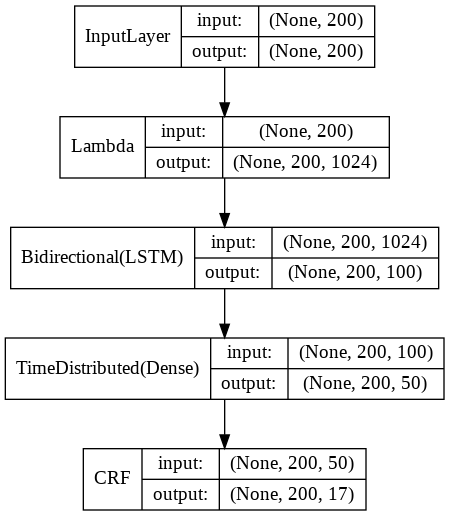

<Figure size 72x72 with 0 Axes>

In [0]:
from keras import regularizers
input = Input(shape=(200,),dtype=tf.string)


embed = Lambda(ElmoEmbedding,  output_shape=( 200,1024))(input)
model = Bidirectional(LSTM(units=50, return_sequences=True,recurrent_dropout=0.1  , kernel_regularizer=regularizers.l2(0.001) ))(embed)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer'
crf = CRF(n_tags, kernel_regularizer=regularizers.l2(0.001))  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
#model.compile(optimizer="rmsprop", loss=crf.loss_function,metrics=[crf_accuracy])
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
model.summary()
from keras.utils import plot_model
from matplotlib import pyplot as plt
plt.figure(figsize=(1,1))
plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=False)

In [0]:
X_tr= X_tr[:6*batch_size]
y_tr = y_tr[:6*batch_size]
history = model.fit(np.array(X_tr), y_tr, epochs=20,verbose=1,batch_size=batch_size,class_weight=class_weights)

Epoch 1/20



192/192 [==============================] - 200s 1s/step - loss: 2.2307 - crf_viterbi_accuracy: 0.7498
Epoch 2/20
192/192 [==============================] - 160s 832ms/step - loss: 1.2261 - crf_viterbi_accuracy: 0.9134
Epoch 3/20
192/192 [==============================] - 159s 827ms/step - loss: 1.1111 - crf_viterbi_accuracy: 0.9129
Epoch 4/20
192/192 [==============================] - 171s 893ms/step - loss: 1.0263 - crf_viterbi_accuracy: 0.9111
Epoch 5/20
192/192 [==============================] - 161s 838ms/step - loss: 0.9596 - crf_viterbi_accuracy: 0.9143
Epoch 6/20
192/192 [==============================] - 162s 846ms/step - loss: 0.9034 - crf_viterbi_accuracy: 0.9147
Epoch 7/20
192/192 [==============================] - 160s 834ms/step - loss: 0.8521 - crf_viterbi_accuracy: 0.9149
Epoch 8/20
192/192 [==============================] - 162s 842ms/step - loss: 0.8054 - crf_viterbi_accuracy: 0.9149
Epoch 9/20
192/192 [==============================] - 170s 883ms/step - loss: 0.7607 -

Predictions

In [0]:
#30% of train set
batch_size=32
X_te= X_te[:2*batch_size]
y_te = y_te[:2*batch_size]
print(len(X_te))
pred_cat = model.predict(np.array(X_te))
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)


In [0]:
#India
batch_size=32
X_test= X_test[:2*batch_size]
print(len(X_te))
pred_cat = model.predict(np.array(X_test))
pred = np.argmax(pred_cat, axis=-1)



64


In [0]:
#China
batch_size=32
X_testchina= X_testchina[:2*batch_size]
print(len(X_te))
pred_cat = model.predict(np.array(X_test))
pred = np.argmax(pred_cat, axis=-1)


In [0]:
idx2tag = {i: w for w, i in tag2idx.items()}
#idx2word = {i: w for w, i in word2idx.items()}
print(idx2tag)

{0: 'I-etime', 1: 'I-trigger', 2: 'B-place', 3: 'B-fname', 4: 'B-target', 5: 'B-participant', 6: 'I-target', 7: 'O', 8: 'B-organizer', 9: 'B-etime', 10: 'I-fname', 11: 'I-loc', 12: 'I-organizer', 13: 'B-trigger', 14: 'I-participant', 15: 'I-place', 16: 'B-loc'}


In [0]:
tagstest=[ (idx2tag[prd]) for i in range (0,len(X_test))  for w,prd in zip(X_test[i], pred[i])]
print(tagstest)
countg=[[x,tagstest.count(x)] for x in set(tagstest)]
print(countg)

['O', 'B-participant', 'O', 'B-organizer', 'I-organizer', 'O', 'O', 'B-trigger', 'O', 'B-place', 'O', 'O', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I-place', 'I

In [0]:
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for i in range (0,len(X_te)):
  print("-------------------------------------------")
  for w, true, prd in zip(X_te[i], y_te_true[i], pred[i]):
    if w != "__PAD__":
        print("{:15}:{:5} ({})".format(w, idx2tag[true], idx2tag[prd]))

Word           (True ): Pred
-------------------------------------------
SAMPLE_START   :O     (O)
May            :B-etime (O)
Day            :I-etime (O)
flags          :B-trigger (B-trigger)
were           :I-trigger (O)
hoisted        :I-trigger (B-trigger)
by             :O     (O)
workers        :B-participant (B-participant)
and            :O     (O)
union          :B-organizer (B-participant)
activists      :B-participant (B-participant)
at             :O     (O)
various        :O     (O)
places         :O     (O)
in             :O     (O)
the            :O     (O)
city           :O     (O)
including      :O     (O)
some           :O     (O)
auto-rickshaw  :B-loc (I-trigger)
stands         :I-loc (O)
.              :O     (O)
-------------------------------------------
SAMPLE_START   :O     (O)
NEW            :O     (O)
DELHI          :O     (O)
:              :O     (O)
Chidambaram    :O     (O)
:              :O     (O)
none           :O     (O)
should         :O     (O)
suppo

In [0]:
!pip install sklearn-crfsuite

     |████████████████████████████████| 757kB 4.1MB/s 


In [0]:
from sklearn_crfsuite.metrics import flat_classification_report
idx2tag = {i: w for w, i in tag2idx.items()}
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

               precision    recall  f1-score   support

      B-etime       0.71      0.19      0.30        26
      B-fname       0.00      0.00      0.00        23
        B-loc       0.00      0.00      0.00        16
  B-organizer       0.50      0.10      0.16        61
B-participant       0.53      0.52      0.52        83
      B-place       0.59      0.57      0.58        35
     B-target       0.20      0.06      0.09        34
    B-trigger       0.74      0.56      0.64        93
      I-etime       0.84      0.50      0.63        32
      I-fname       0.67      0.44      0.53        78
        I-loc       0.00      0.00      0.00        40
  I-organizer       0.71      0.65      0.67        93
I-participant       0.00      0.00      0.00        19
      I-place       1.00      1.00      1.00      3594
     I-target       0.00      0.00      0.00        23
    I-trigger       0.33      0.04      0.06        28
            O       0.85      0.98      0.91      2122

     acc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:

print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for i in range (0,len(X_te)):
  print("-------------------------------------------")
  for w, true, prd in zip(X_te[i], y_te_true[i], pred[i]):
    if w != "__PAD__":
        print("{:15}:{:5} ({})".format(w, idx2tag[true], idx2tag[prd]))

Word           (True ): Pred
-------------------------------------------
SAMPLE_START   :O     (O)
May            :B-etime (O)
Day            :I-etime (O)
flags          :B-trigger (B-trigger)
were           :I-trigger (O)
hoisted        :I-trigger (B-trigger)
by             :O     (O)
workers        :B-participant (B-participant)
and            :O     (O)
union          :B-organizer (B-participant)
activists      :B-participant (B-participant)
at             :O     (O)
various        :O     (O)
places         :O     (O)
in             :O     (O)
the            :O     (O)
city           :O     (O)
including      :O     (O)
some           :O     (O)
auto-rickshaw  :B-loc (O)
stands         :I-loc (O)
.              :O     (O)
-------------------------------------------
SAMPLE_START   :O     (O)
NEW            :O     (O)
DELHI          :O     (O)
:              :O     (O)
Chidambaram    :O     (O)
:              :O     (O)
none           :O     (O)
should         :O     (O)
support      

In [0]:
from sklearn_crfsuite.metrics import flat_classification_report
idx2tag = {i: w for w, i in tag2idx.items()}
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

               precision    recall  f1-score   support

      B-etime       0.83      0.54      0.65        56
      B-fname       0.00      0.00      0.00        34
        B-loc       1.00      0.05      0.09        21
  B-organizer       0.38      0.22      0.27        97
B-participant       0.63      0.63      0.63       124
      B-place       0.57      0.68      0.62        63
     B-target       0.45      0.09      0.14        58
    B-trigger       0.77      0.66      0.71       164
      I-etime       0.78      0.69      0.73        65
      I-fname       0.66      0.49      0.56       107
        I-loc       0.62      0.18      0.28        44
  I-organizer       0.68      0.66      0.67       129
I-participant       0.00      0.00      0.00        22
      I-place       1.00      0.99      1.00      1877
     I-target       0.67      0.11      0.19        37
    I-trigger       0.16      0.06      0.09        47
            O       0.88      0.97      0.92      3455

     acc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ENhanced Bi-LSTM CRF

In [0]:
word_in = Input(shape=(max_len,))
from keras import regularizers
input = Input(shape=(200,),dtype=tf.string)
pos_in = Input(shape=(200,26,))
dict_in=Input(shape=(200,5))

embed = Lambda(ElmoEmbedding,  output_shape=( 200,1024))(input)

x = concatenate([embed, pos_in,dict_in])

model1 = Bidirectional(LSTM(units=50, return_sequences=True,recurrent_dropout=0.1  , kernel_regularizer=regularizers.l2(0.001) ))(x)  # variational biLSTM
model1 = TimeDistributed(Dense(50, activation="relu"))(model1)  # a dense layer as suggested by neuralNer'
crf = CRF(n_tags, kernel_regularizer=regularizers.l2(0.001))  # CRF layer
out = crf(model1)  # output

model1 = Model([input, pos_in,dict_in], out)
model1.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
#model.compile(optimizer="rmsprop", loss=crf.loss_function,metrics=[crf_accuracy])
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
model1.summary()
from keras.utils import plot_model
from matplotlib import pyplot as plt
plt.figure(figsize=(1,1))
plot_model(model1, to_file='model_plot2.png', show_shapes=True, show_layer_names=False)